diff_r2: 0.5434299320115994
diff_mse: 0.16622373900010773
diff_mae: 0.2837667404424906
0.6374316419393228
282.4549441504505
12.676025519631427


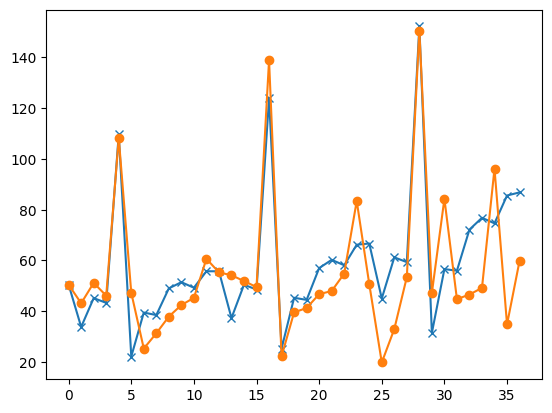

In [27]:
## train 


import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima



file_path = './source_data/A1backup.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='polynomial',order=3)



def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff_data = difference(data['sales'].values,1)
diff_data = pd.DataFrame(diff_data)
diff_data.index = data.index[1:]

def scale(train,test):
    # 创建一个缩放器，将数据集中的数据缩放到[-1,1]的取值范围中
    scaler=MinMaxScaler(feature_range=(-1,1))
    # 使用数据来训练缩放器
    scaler=scaler.fit(train)
    # 使用缩放器来将训练集和测试集进行缩放
    train_scaled=scaler.transform(train)
    test_scaled=scaler.transform(test)
    return scaler,train_scaled,test_scaled

train_num = 80
# scaler, train_data,test_data = scale(diff_data[:train_num],diff_data[train_num:])
train_data,test_data = diff_data[:train_num],diff_data[train_num:]

train_data = pd.DataFrame(train_data)
train_data.index = data.index[:train_num]
train_data.columns =['y']
test_data = pd.DataFrame(test_data)
test_data.index = data.index[train_num:-1]
test_data.columns =['y']




model = auto_arima(train_data[44:], seasonal=True, m=12)
test_predict = model.predict(test_data.shape[0])


test_predict.index = test_data.index
# test_predict = scaler.inverse_transform(test_predict).reshape(-1)

# test_data = scaler.inverse_transform(test_data).reshape(-1)
# train_data = scaler.inverse_transform(train_data)
# test_predict.plot(marker='x')

print("diff_r2:",r2_score(test_data['y'],test_predict))
print("diff_mse:",mean_squared_error(test_data['y'],test_predict))
print("diff_mae:",mean_absolute_error(test_data['y'],test_predict))


def inverse_difference(start,data):
    l =  [start]
    s = start
    for i in data:
        s+=i
        l.append(s)        
    return pd.DataFrame(l)

inverse_predict =  inverse_difference(train_data.y.sum()+data['sales'][0],test_predict.values)

inverse_predict = inverse_predict.apply(np.expm1)
# # # inverse_predict



inverse_test = inverse_difference(train_data.y.sum()+data['sales'][0],test_data.y)
inverse_test = inverse_test.apply(np.expm1)



print(r2_score(inverse_test[0],inverse_predict[0]))
print(mean_squared_error(inverse_test[0],inverse_predict[0]))
print(mean_absolute_error(inverse_test[0],inverse_predict[0]))

inverse_predict[0].plot(marker='x')
inverse_test[0].plot(marker='o')

inverse_predict[0].to_excel('./temp.xlsx')

In [7]:
## test


import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima



file_path = './source_data/A1backup.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]

data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='polynomial',order=3)



def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff_data = difference(data['sales'].values,1)
diff_data = pd.DataFrame(diff_data)
diff_data.index = data.index[1:]

def scale(train,test):
    # 创建一个缩放器，将数据集中的数据缩放到[-1,1]的取值范围中
    scaler=MinMaxScaler(feature_range=(-1,1))
    # 使用数据来训练缩放器
    scaler=scaler.fit(train)
    # 使用缩放器来将训练集和测试集进行缩放
    train_scaled=scaler.transform(train)
    test_scaled=scaler.transform(test)
    return scaler,train_scaled,test_scaled


# scaler, train_data,test_data = scale(diff_data[:train_num],diff_data[train_num:])
train_data = diff_data

train_data = pd.DataFrame(train_data)
train_data.index = data.index[:-1]
train_data.columns =['y']





model = auto_arima(train_data[44:], seasonal=True, m=12)
test_predict = model.predict(22)



# test_predict = scaler.inverse_transform(test_predict).reshape(-1)

# test_data = scaler.inverse_transform(test_data).reshape(-1)
# train_data = scaler.inverse_transform(train_data)
# test_predict.plot(marker='x')



def inverse_difference(start,data):
    l =  [start]
    s = start
    for i in data:
        s+=i
        l.append(s)        
    return pd.DataFrame(l)

inverse_predict =  inverse_difference(train_data.y.sum()+data['sales'][0],test_predict.values)

inverse_predict = inverse_predict.apply(np.expm1)
# print("train_end_date date:%s"%train_data.index[-1])
# print(inverse_predict)
datetime_series = pd.Series(pd.date_range(train_data.index[-1], periods=23, freq="m"))
inverse_predict['date'] = datetime_series
print(inverse_predict)

             0       date
0    59.816000 2020-08-31
1    35.038953 2020-09-30
2    44.567928 2020-10-31
3    53.860608 2020-11-30
4   134.008703 2020-12-31
5    38.810302 2021-01-31
6    53.586972 2021-02-28
7    43.379992 2021-03-31
8    47.775426 2021-04-30
9    50.507379 2021-05-31
10   68.555585 2021-06-30
11   52.554480 2021-07-31
12   57.343878 2021-08-31
13   35.050072 2021-09-30
14   44.581987 2021-10-31
15   53.877534 2021-11-30
16  134.050358 2021-12-31
17   38.822585 2022-01-31
18   53.603814 2022-02-28
19   43.393685 2022-03-31
20   47.790475 2022-04-30
21   50.523271 2022-05-31
22   68.577045 2022-06-30


<AxesSubplot:xlabel='date'>

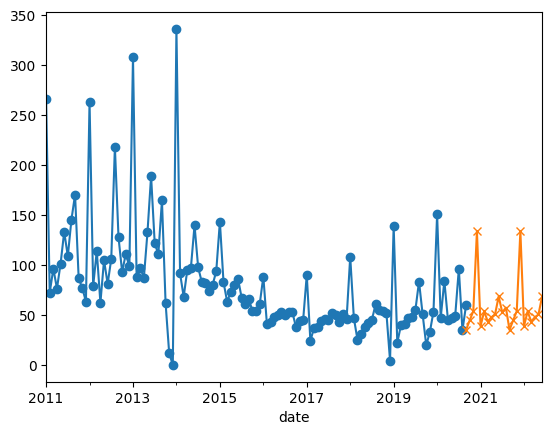

In [14]:
# final_data
import pandas 
file_path = './final_result/A1.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data.set_index(raw_data['date'],inplace=True)
raw_data['sales'][:-20].plot(marker='o')
inverse_predict.set_index(inverse_predict['date'],inplace=True)
inverse_predict[0][1:].plot(marker='x')
# raw_data['sales'][-20:].plot(marker='x')


<AxesSubplot:xlabel='date'>

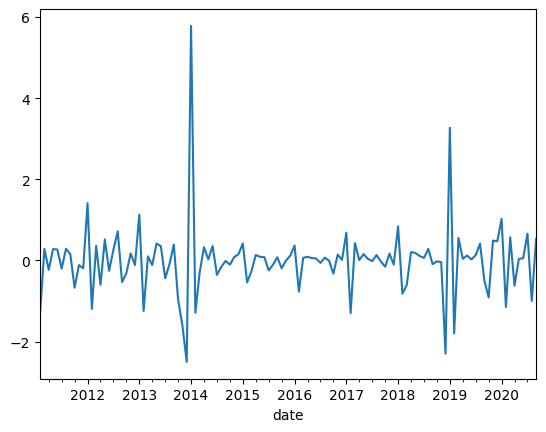

In [19]:
# 差分数据图
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima


file_path = './source_data/A1.xlsx'
raw_data = pd.read_excel(file_path)
raw_data.columns = ['date1','id1','id2','sales','values']
raw_data['date']=pd.to_datetime(raw_data['date1'],format="%Y%m")
raw_data = raw_data[raw_data['id1']>=0]
data = raw_data[['date','sales']]
data['sales'] = data['sales'].apply(np.log1p)
data.set_index('date', inplace=True)
data = data.interpolate(method='polynomial',order=3)



def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)

diff_data = difference(data['sales'].values,1)
diff_data = pd.DataFrame(diff_data)
diff_data.index = data.index[1:]
diff_data.to_excel('./temp.xlsx')
diff_data[0].plot()